In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib

print("All libraries imported successfully")




All libraries imported successfully


In [3]:
import tensorflow as tf
print(tf.__version__)


2.13.0


In [4]:
import sys
print(sys.executable)


C:\Users\n\Desktop\Intelligent Health Monitoring\.venv2\Scripts\python.exe


In [5]:
# Cell 2: Load Dataset
DATA_PATH = "../Data/processed/acc_features.csv"
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()







Dataset shape: (2913, 12)


,subject_id,activity,ax_std,ay_std,az_std,ax_rms,ay_rms,az_rms,sma,ax_energy,ay_energy,az_energy
0,s12,run,0.869638,0.956757,1.062938,0.869656,0.957057,1.063297,2.305827,0.756302,0.915958,1.130601
1,s12,sit,0.010238,0.012713,0.014374,0.010239,0.012715,0.014375,0.029978,0.000105,0.000162,0.000207
2,s12,sit,0.009752,0.012608,0.013975,0.009753,0.012610,0.013983,0.028985,0.000095,0.000159,0.000196
3,s12,sit,0.009429,0.011982,0.014114,0.009439,0.011991,0.014128,0.028197,0.000089,0.000144,0.000200
4,s12,walk,0.727310,0.623480,0.862876,0.729464,0.628300,0.862940,1.748904,0.532117,0.394761,0.744666


In [6]:
print("Missing values per column:\n", df.isnull().sum())


Missing values per column:
 subject_id    0
activity      0
ax_std        0
ay_std        0
az_std        0
ax_rms        0
ay_rms        0
az_rms        0
sma           0
ax_energy     0
ay_energy     0
az_energy     0
dtype: int64


In [7]:
# Cell 3: Separate features and labels
X = df.drop(columns=["subject_id", "activity"])
y = df["activity"]

print("Feature matrix shape:", X.shape)
print("Activities:", y.unique())
print("All features numeric:", all([np.issubdtype(dt, np.number) for dt in X.dtypes]))



Feature matrix shape: (2913, 10)
Activities: ['run' 'sit' 'walk']
All features numeric: True


In [8]:
# Cell 4: Encode activity labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Activity encoding:", dict(zip(le.classes_, le.transform(le.classes_))))


Activity encoding: {'run': 0, 'sit': 1, 'walk': 2}


In [9]:
# Cell 5: Function to sort subjects numerically

# Sort subjects numerically
#LEAVE ONE SUBJECT OUT!
# Cell 6: Split subjects into train/test (70%-30%)
def subject_number(s):
    return int(s.replace("s", ""))


subjects = sorted(df["subject_id"].unique(), key=subject_number)

split_idx = int(0.7 * len(subjects))
train_subjects = subjects[:split_idx]
test_subjects = subjects[split_idx:]

train_df = df[df["subject_id"].isin(train_subjects)]
test_df = df[df["subject_id"].isin(test_subjects)]

X_train = train_df.drop(columns=["subject_id", "activity"])
y_train = le.transform(train_df["activity"])
X_test = test_df.drop(columns=["subject_id", "activity"])
y_test = le.transform(test_df["activity"])

print("Train subjects:", train_subjects)
print("Test subjects:", test_subjects)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)






Train subjects: ['s2', 's12', 's14']
Test subjects: ['s16', 's22']
Train shape: (1750, 10)
Test shape: (1163, 10)


In [10]:
print("Train activity distribution:\n", train_df["activity"].value_counts())
print("Test activity distribution:\n", test_df["activity"].value_counts())

# OPTIONAL: compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)



Train activity distribution:
 activity
sit     585
walk    583
run     582
Name: count, dtype: int64
Test activity distribution:
 activity
run     390
sit     387
walk    386
Name: count, dtype: int64
Class weights: {0: 1.002290950744559, 1: 0.9971509971509972, 2: 1.0005717552887363}


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [32]:
#MLP MODEL
from tensorflow.keras import regularizers

num_classes = len(np.unique(y_train))

model = Sequential([
    Dense(
        128,
        activation='relu',
        input_shape=(X_train_scaled.shape[1],),
        kernel_regularizer=regularizers.l2(0.001)
    ),
    Dropout(0.1),

    Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ),
    Dropout(0.1),

    Dense(
        32,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ),
    Dropout(0.1),

    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()






Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               1408      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                

In [36]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=16,# train longer
    batch_size=32,#smaller batch size helps
    callbacks=[early_stop],
    class_weight=class_weights,  # handle class imbalance
    shuffle=True
)






Epoch 1/16
44/44 [==============================] - 0s 4ms/step - loss: 0.3296 - accuracy: 0.9257 - val_loss: 0.1307 - val_accuracy: 1.0000
Epoch 2/16
44/44 [==============================] - 0s 3ms/step - loss: 0.2809 - accuracy: 0.9364 - val_loss: 0.1178 - val_accuracy: 1.0000
Epoch 3/16
44/44 [==============================] - 0s 3ms/step - loss: 0.2585 - accuracy: 0.9407 - val_loss: 0.1124 - val_accuracy: 1.0000
Epoch 4/16
44/44 [==============================] - 0s 3ms/step - loss: 0.2321 - accuracy: 0.9471 - val_loss: 0.1052 - val_accuracy: 1.0000
Epoch 5/16
44/44 [==============================] - 0s 4ms/step - loss: 0.2319 - accuracy: 0.9536 - val_loss: 0.1016 - val_accuracy: 1.0000
Epoch 6/16
44/44 [==============================] - 0s 3ms/step - loss: 0.2199 - accuracy: 0.9536 - val_loss: 0.0956 - val_accuracy: 1.0000
Epoch 7/16
44/44 [==============================] - 0s 3ms/step - loss: 0.2151 - accuracy: 0.9550 - val_loss: 0.0951 - val_accuracy: 1.0000
Epoch 8/16
44/44 [==

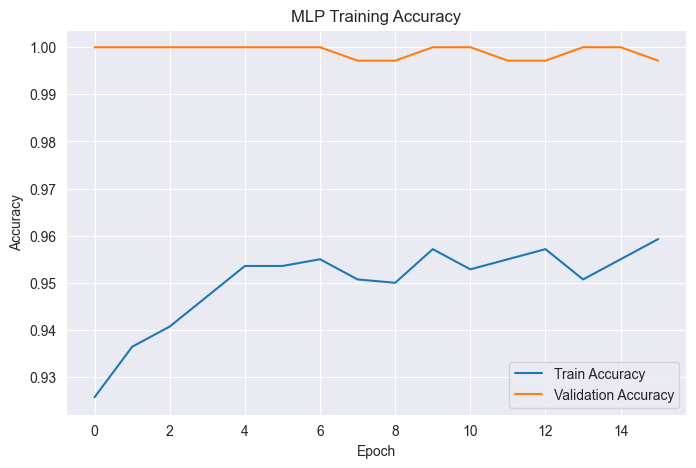

In [37]:
# Cell 8: PLOT TRAINING HISTORY
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP Training Accuracy')
plt.legend()
plt.show()






In [38]:
# EVALUATION
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test Accuracy:", test_acc)

y_pred = np.argmax(model.predict(X_test_scaled), axis=1)

Test Accuracy: 0.7523645758628845
37/37 [==============================] - 0s 1ms/step


In [24]:
# EVALUATION
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test Accuracy:", test_acc)

y_pred = np.argmax(model.predict(X_test_scaled), axis=1)





Test Accuracy: 0.7515047192573547
37/37 [==============================] - 0s 1ms/step



Test Accuracy: 75.24%

Classification Report:
              precision    recall  f1-score   support

         run       0.61      0.92      0.74       390
         sit       0.93      1.00      0.96       387
        walk       0.81      0.33      0.47       386

    accuracy                           0.75      1163
   macro avg       0.78      0.75      0.72      1163
weighted avg       0.78      0.75      0.72      1163



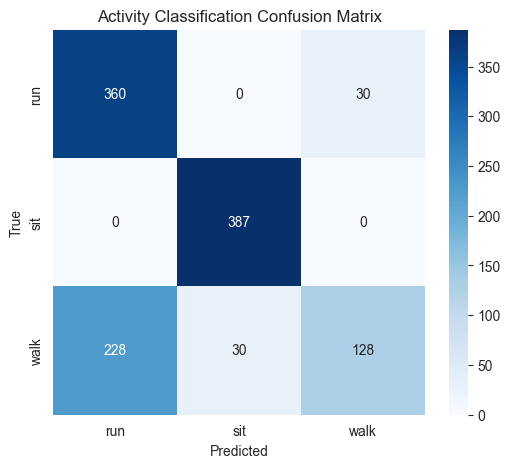

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred) * 100  # convert to percentage
print(f"\nTest Accuracy: {test_accuracy:.2f}%\n")  # print at the top

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Activity Classification Confusion Matrix")
plt.show()




In [40]:
# Cell: Save trained MLP model and scaler
import os
import joblib
from tensorflow.keras.models import save_model

# Ensure models directory exists


# Save TensorFlow MLP model (SavedModel format)
model.save("Deep Learning Module/models/activity_classification_mlp")  # TensorFlow model

# Save scaler and label encoder using joblib
joblib.dump(scaler, "Deep Learning Module/models/activity_scaler.pkl")
joblib.dump(le, "Deep Learning Module/models/activity_label_encoder.pkl")

# Save feature names to avoid mismatch in app.py
joblib.dump(X_train.columns.tolist(), "Deep Learning Module/models/activity_features.pkl")

print("✅ TensorFlow MLP model, scaler, label encoder, and feature names saved successfully")




INFO:tensorflow:Assets written to: Deep Learning Module/models/activity_classification_mlp\assets


INFO:tensorflow:Assets written to: Deep Learning Module/models/activity_classification_mlp\assets


✅ TensorFlow MLP model, scaler, label encoder, and feature names saved successfully


In [41]:
import sys
print(sys.version)

3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [42]:
import numpy as np
print(np.__version__)


1.26.4
